In [1]:
import sys;

import torch;
import torch.nn as nn;
import torch.optim as optim

import numpy as np;
import pickle;

import matplotlib.pyplot as plt;

import pdb
import time

import math

import os

print("Packages:");
print("torch.__version__ = " + str(torch.__version__));
print("numpy.__version__ = " + str(np.__version__));

Packages:
torch.__version__ = 1.5.0
numpy.__version__ = 1.18.1


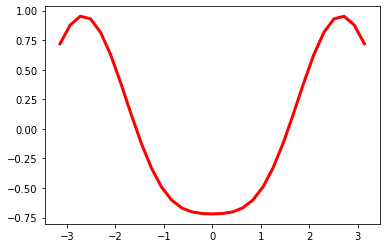

In [2]:
# Discretize a domain
C = math.pi
h = 2*C/(30)
x = np.arange(-C, C+h, h)
N = len(x)

# Number of functions for our data
M = 100

z_tensor = torch.zeros(M,1,1,N)
discretization = torch.zeros(M,1,1,N)
z_deriv_tensor = torch.zeros(M,1,1,N)

# Generate data
for i in range(0,M):
    a = np.random.uniform(-1,1,1)
    b = np.random.uniform(-1,1,1)
    z = a*x*np.sin(2*x) + b*np.cos(x)
#    z = a*np.sin(x) + b*np.sin(2*x) 
#    z = a*np.sin(x)
#    z = a*np.exp(-b*(x**2))
    
    z_tensor[i,:,:] = torch.tensor(z)
    z_tensor = z_tensor.float()
    discretization[i,0,0,:] = torch.tensor(x)
    
    for j in range(1,len(z)-1):
        z_deriv_tensor[i,0,0,j] = (z[j+1] - 2*z[j] + z[j-1])/(h**2)
    
    
# Reshape tensor
discretization_reshape = torch.reshape(discretization, (-1,))

# Initialize tensors for input data

z_NN_input_branch_0 = z_tensor.repeat(1,N,1,1)
z_NN_input_branch_np = z_NN_input_branch_0.detach().numpy().squeeze()
z_NN_input_branch_np = np.reshape(z_NN_input_branch_np, (N*M,N))


z_NN_input_branch = torch.tensor(z_NN_input_branch_np)
z_NN_input_trunk = discretization_reshape.repeat(1,1,1,1)
z_NN_input_trunk = torch.reshape(z_NN_input_trunk, (N*M,1))
z_NN_target = torch.reshape(z_deriv_tensor, (N*M,1))

#print(z_NN_target)
#print(z_NN_input_trunk)
#print(z_NN_target)

    

plt.plot(x,z, color='red', linewidth=3)

In [3]:
# Create neural networks for Unstacked DeepONet

class Unstacked_Branch(nn.Module):
    def __init__(self):
        super(Unstacked_Branch, self).__init__()
        self.layer1 = nn.Linear(N, 200, bias=True)
        self.layer2 = nn.Linear(200,2, bias=True)
        self.activation = nn.ReLU()
    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        return out
    
    
class Trunk(nn.Module):
    def __init__(self):
        super(Trunk, self).__init__()
        self.layer1 = nn.Linear(1, 200, bias=True)
        self.layer2 = nn.Linear(200,2, bias=True)
        self.activation = nn.ReLU()
    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        return out


Unstacked_Branch = Unstacked_Branch()
Trunk = Trunk()
print(Unstacked_Branch)
print(Trunk)

Unstacked_Branch(
  (layer1): Linear(in_features=31, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=2, bias=True)
  (activation): ReLU()
)
Trunk(
  (layer1): Linear(in_features=1, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=2, bias=True)
  (activation): ReLU()
)


In [7]:
# Define PINN loss
def MSE_loss(u, f):
    loss = torch.sum( (u-f)**2)
    return loss;

loss_func = MSE_loss
#loss_func = torch.nn.MSELoss()

In [27]:
###### Iteratively run this code to train the network

I = 1000

loss_vector = np.zeros(shape=(I,1))
index_vector = np.zeros(shape=(I,1))
num_epochs = I
target = z_NN_target
for i in np.arange(0,num_epochs):
    index_vector[i-1] = i
    
    optimizer_1 = optim.Adam(Unstacked_Branch.parameters(), lr=0.00001); optimizer_1.zero_grad()  
    optimizer_2 = optim.Adam(Trunk.parameters(), lr=0.00001); optimizer_2.zero_grad() 
    output_1 = Unstacked_Branch(z_NN_input_branch); output_2 = Trunk(z_NN_input_trunk)
        
    loss = loss_func(target, torch.mul(output_1[:,0:1], output_2[:,0:1]) + torch.mul(output_1[:,1:2], output_2[:,1:2]))
    loss.backward()
    loss_vector[i-1] = loss.detach()
    optimizer_1.step(); optimizer_2.step()

    
print("DNN training finished.")
print(loss_vector[I-1])


DNN training finished.
[1364.60302734]


<function matplotlib.pyplot.show(*args, **kw)>

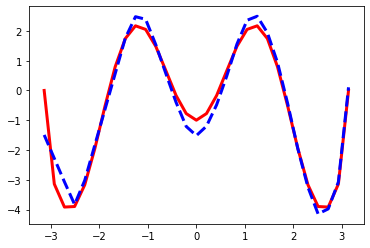

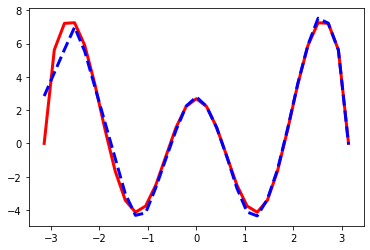

In [28]:
y = torch.mul(output_1[:,0:1], output_2[:,0:1]) + torch.mul(output_1[:,1:2], output_2[:,1:2])
plt.figure(1)
plt.plot(x, target.detach().numpy()[0:31], color='red', linewidth=3)
plt.plot(x,y.detach().numpy()[0:31], linestyle='dashed', color='blue', linewidth=3)
plt.show

plt.figure(2)
plt.plot(x, target.detach().numpy()[31:62], color='red', linewidth=3)
plt.plot(x,y.detach().numpy()[31:62], linestyle='dashed', color='blue', linewidth=3)
plt.show

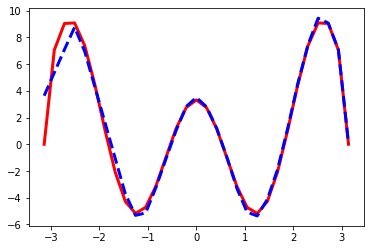

In [29]:
# Evaluate our NN on a test data set

M = 10

z_tensor_test = torch.zeros(M,1,1,N)
discretization_test = torch.zeros(M,1,1,N)
z_deriv_tensor_test = torch.zeros(M,1,1,N)

# Generate data
for i in range(0,M):
    a = np.random.uniform(-1,1,1)
    b = np.random.uniform(0,0.2,1)
    z = a*x*np.sin(2*x)  #+ b*np.sin(2*x)
#    z = a*np.exp(-b*(x**2))
    
    z_tensor_test[i,:,:] = torch.tensor(z)
    z_tensor_test = z_tensor_test.float()
    discretization_test[i,0,0,:] = torch.tensor(x)
    
    for j in range(1,len(z)-1):
        z_deriv_tensor_test[i,0,0,j] = (z[j+1] - 2*z[j] + z[j-1])/(h**2)
    
    
# Reshape tensor
discretization_reshape_test = torch.reshape(discretization_test, (-1,))

# Initialize tensors for input data

z_NN_input_branch_0_test = z_tensor_test.repeat(1,N,1,1)
z_NN_input_branch_np_test = z_NN_input_branch_0_test.detach().numpy().squeeze()
z_NN_input_branch_np_test = np.reshape(z_NN_input_branch_np_test, (N*M,N))


z_NN_input_branch_test = torch.tensor(z_NN_input_branch_np_test)
z_NN_input_trunk_test = discretization_reshape_test.repeat(1,1,1,1)
z_NN_input_trunk_test = torch.reshape(z_NN_input_trunk_test, (N*M,1))
z_NN_target_test = torch.reshape(z_deriv_tensor_test, (N*M,1))

test_output_1 = Unstacked_Branch(z_NN_input_branch_test)
test_output_2 = Trunk(z_NN_input_trunk_test)
test_output = torch.mul(test_output_1[:,0:1], test_output_2[:,0:1]) + torch.mul(test_output_1[:,1:2], test_output_2[:,1:2])


plt.plot(x, z_NN_target_test.detach().numpy()[0:31], color='red', linewidth=3)
plt.plot(x, test_output.detach().numpy()[0:31], linestyle='dashed', color='blue', linewidth=3)

In [ ]:
##### Move on to Stacked DeepONets ########

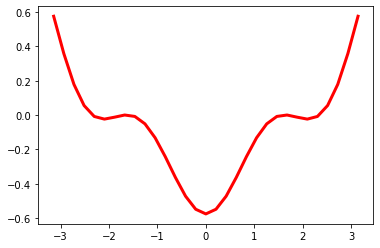

In [6]:
######## Repeat process with new data, but for a Stacked DeepONet ##########

# Discretize a domain
C = math.pi
h = 2*C/(30)
x = np.arange(-C, C+h, h)
N = len(x)

# Number of functions for our data
M = 100

z_tensor_2 = torch.zeros(M,1,1,N)
discretization_2 = torch.zeros(M,1,1,N)
z_deriv_tensor_2 = torch.zeros(M,1,1,N)

# Generate data
for i in range(0,M):
    a = np.random.uniform(-1,1,1)
    b = np.random.uniform(-1,1,1)
    z = a*x*np.sin(2*x) + b*np.cos(x)
#    z = a*np.sin(x) + b*np.sin(2*x) 
#    z = a*np.sin(x)
#    z = a*np.exp(-b*(x**2))
    
    z_tensor_2[i,:,:] = torch.tensor(z)
    z_tensor_2 = z_tensor_2.float()
    discretization_2[i,0,0,:] = torch.tensor(x)
    
    for j in range(1,len(z)-1):
        z_deriv_tensor_2[i,0,0,j] = (z[j+1] - 2*z[j] + z[j-1])/(h**2)
    
    
# Reshape tensor
discretization_reshape_2 = torch.reshape(discretization_2, (-1,))

# Initialize tensors for input data

z_NN_input_branch_0_2 = z_tensor_2.repeat(1,N,1,1)
z_NN_input_branch_np_2 = z_NN_input_branch_0_2.detach().numpy().squeeze()
z_NN_input_branch_np_2 = np.reshape(z_NN_input_branch_np_2, (N*M,N))


z_NN_input_branch_2 = torch.tensor(z_NN_input_branch_np_2)
z_NN_input_trunk_2 = discretization_reshape_2.repeat(1,1,1,1)
z_NN_input_trunk_2 = torch.reshape(z_NN_input_trunk_2, (N*M,1))
z_NN_target_2 = torch.reshape(z_deriv_tensor_2, (N*M,1))

#print(z_NN_target)
#print(z_NN_input_trunk)
#print(z_NN_target)

    

plt.plot(x,z, color='red', linewidth=3)

In [24]:
# Create neural networks for Stacked DeepONet

class Stacked_Branch(nn.Module):
    def __init__(self):
        super(Stacked_Branch, self).__init__()
        self.layer1 = nn.Linear(N, 200, bias=True)
        self.layer2 = nn.Linear(200,1)
        self.activation = nn.ReLU()
    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        return out
    
    
class Trunk(nn.Module):
    def __init__(self):
        super(Trunk, self).__init__()
        self.layer1 = nn.Linear(1, 200, bias=True)
        self.layer2 = nn.Linear(200,2)
        self.activation = nn.ReLU()
    def forward(self, x):
        out = self.layer1(x)
        out = self.activation(out)
        out = self.layer2(out)
        return out


Stacked_Branch_1 = Stacked_Branch()
Stacked_Branch_2 = Stacked_Branch()
Trunk = Trunk()
print(Stacked_Branch_1)
print(Stacked_Branch_2)
print(Trunk)

Stacked_Branch(
  (layer1): Linear(in_features=31, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=1, bias=True)
  (activation): ReLU()
)
Stacked_Branch(
  (layer1): Linear(in_features=31, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=1, bias=True)
  (activation): ReLU()
)
Trunk(
  (layer1): Linear(in_features=1, out_features=200, bias=True)
  (layer2): Linear(in_features=200, out_features=2, bias=True)
  (activation): ReLU()
)


In [22]:
I = 1000

loss_vector = np.zeros(shape=(I,1))
index_vector = np.zeros(shape=(I,1))
num_epochs = I
target = z_NN_target
for i in np.arange(0,num_epochs):
    index_vector[i-1] = i
    
    optimizer_1 = optim.Adam(Stacked_Branch_1.parameters(), lr=0.00001); optimizer_1.zero_grad() 
    optimizer_2 = optim.Adam(Stacked_Branch_2.parameters(), lr=0.00001); optimizer_2.zero_grad()
    optimizer_3 = optim.Adam(Trunk.parameters(), lr=0.00001); optimizer_3.zero_grad() 
    output_1 = Stacked_Branch_1(z_NN_input_branch); 
    output_2 = Stacked_Branch_2(z_NN_input_branch)
    output_3 = Trunk(z_NN_input_trunk)
        
    loss = loss_func(target, torch.mul(output_1, output_3[:,0:1]) + torch.mul(output_2, output_3[:,1:2]))
    loss.backward()
    loss_vector[i-1] = loss.detach()
    optimizer_1.step(); optimizer_2.step();
    optimizer_3.step();

    
print("DNN training finished.")
print(loss_vector[I-1])


DNN training finished.
[3000.06152344]


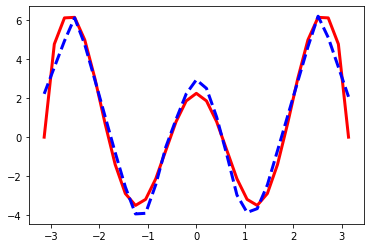

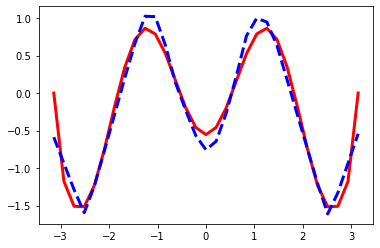

In [23]:
y = torch.mul(output_1, output_3[:,0:1]) + torch.mul(output_2, output_3[:,1:2])

plt.figure(1)
plt.plot(x, target.detach().numpy()[0:31], color='red', linewidth=3)
plt.plot(x, y.detach().numpy()[0:31], linestyle='dashed', color='blue', linewidth=3)

plt.figure(2)
plt.plot(x, target.detach().numpy()[31:62], color='red', linewidth=3)
plt.plot(x, y.detach().numpy()[31:62], linestyle='dashed', color='blue', linewidth=3)